<a href="https://colab.research.google.com/github/Arseniy-Polyakov/machine_learning_course/blob/main/Task_2_Vectorization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Установим библиотеки и импортируем модули для обработки и векторизации текста

In [2]:
!pip install gensim numpy==1.23.5 fasttext

In [28]:
import re
import nltk
import json
import kagglehub
import fasttext
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

Загрузим словари стоп-слов, сегментации и стеммер

In [4]:
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("punkt_tab")
stemmer = WordNetLemmatizer()
stopwords = stopwords.words("english")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Загружаем [датасет](https://www.kaggle.com/datasets/kkhubiev/russian-financial-news/data) с пространства Kaggle. Датасет посвящен новостям из финансовой сферы русских СМИ

In [5]:
dataset_path = kagglehub.dataset_download("kkhubiev/russian-financial-news")
dataset_path

'/kaggle/input/russian-financial-news'

Извлекаем из датасета тексты новостей

In [6]:
with open("/kaggle/input/russian-financial-news/RussianFinancialNews/news_descriptions/news_descriptions_GPT4o.json", "rt") as file:
  news_str = file.read()
  news_json = json.loads(news_str)
texts = [news_json[f"{i}"]["thinking"] for i in range(len(news_json))]
texts_sentences = [nltk.sent_tokenize(article) for article in texts]
texts_sentences[:5]

[["The article discusses Gazprom's production figures, highlighting a discrepancy between gas and oil revenue, and mentioning potential market changes in Russia's energy strategy.",
  'This is a financial report as it concerns company performance metrics (revenue figures) and an upcoming policy decision that could affect the gas market.'],
 ['The article title suggests it is about a community rating of stocks by RDV members, which indicates it may be an advertisement of the RDV community activities or opinions.',
  'Since RDV articles often involve community inputs, marking it as advertising makes sense.',
  'It does not mention any specific countries or sectors directly, nor does it highlight any specific tickers.',
  'The sentiment is neutral as it is merely informative about an internal rating or poll.'],
 ['The article discusses the decline in oil prices and its potential impact on markets, specifically mentioning Brent and Urals oil.',
  'It connects to global oil markets and OPEC

Препроцессинг текста: Приведение к нижнему регистру; удаление знаков препинания, символов из других алфавитов, стоп-слов; токенизация; стемминг

In [7]:
def preprocessing(text: str) -> str:
  text_cleaned = re.sub(r"[^a-z0-9\-\s]", "", text.lower())
  text_stem = [stemmer.lemmatize(token) for token in text_cleaned.split()]
  text_preprocessed = [token for token in text_stem if token not in stopwords]
  return text_preprocessed

In [8]:
texts_preprocessed = [preprocessing(sentence) for article in texts_sentences for sentence in article]
texts_preprocessed[:5]

[['article',
  'discusses',
  'gazproms',
  'production',
  'figure',
  'highlighting',
  'discrepancy',
  'gas',
  'oil',
  'revenue',
  'mentioning',
  'potential',
  'market',
  'change',
  'russia',
  'energy',
  'strategy'],
 ['financial',
  'report',
  'concern',
  'company',
  'performance',
  'metric',
  'revenue',
  'figure',
  'upcoming',
  'policy',
  'decision',
  'could',
  'affect',
  'gas',
  'market'],
 ['article',
  'title',
  'suggests',
  'community',
  'rating',
  'stock',
  'rdv',
  'member',
  'indicates',
  'may',
  'advertisement',
  'rdv',
  'community',
  'activity',
  'opinion'],
 ['since',
  'rdv',
  'article',
  'often',
  'involve',
  'community',
  'input',
  'marking',
  'advertising',
  'make',
  'sense'],
 ['doe',
  'mention',
  'specific',
  'country',
  'sector',
  'directly',
  'doe',
  'highlight',
  'specific',
  'ticker']]

Обучаем модель Word2Vec

In [25]:
w2v_model = Word2Vec(sentences=texts_preprocessed, window=5, min_count=1, workers=4, sg=0)

Найдем 10 самых близких семантически близких слов к слову "investor"

In [30]:
similar_to_investor_w2v = w2v_model.wv.most_similar(["investor"])
similar_to_investor_w2v_words = [item[0] for item in similar_to_investor_w2v]
similar_to_investor_w2v_words

['stakeholder',
 'shareholder',
 'investment',
 'watcher',
 'negatively',
 'perception',
 'positively',
 'participant',
 'maximizing',
 'rusolovos']

Визуализируем близкие семантические слова (модель Word2Vec) с помощью графа

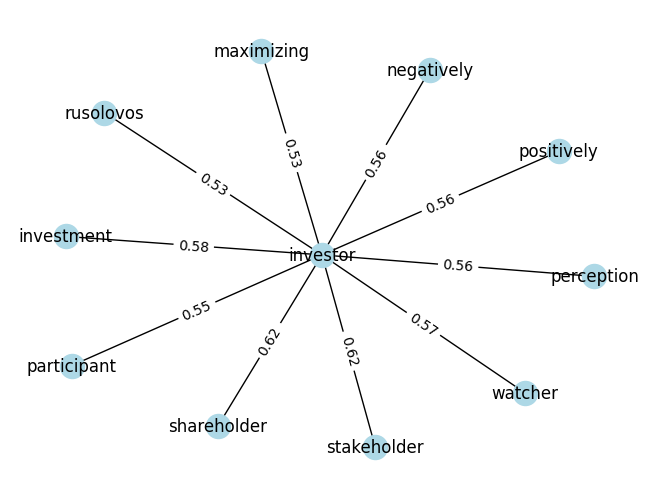

In [32]:
graph = nx.Graph()
graph.add_nodes_from(similar_to_investor_w2v_words)
for i in range(len(similar_to_investor_w2v)):
  graph.add_edge("investor", similar_to_investor_w2v[i][0], weight=similar_to_investor_w2v[i][1])
pos = nx.spring_layout(graph)
nx.draw(graph, pos, with_labels=True, node_color='lightblue')
edge_labels = {(u, v): f"{d['weight']:.2f}" for u, v, d in graph.edges(data=True)}
nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels)
plt.show()

Загрузим предобработанный текст для модели fasttext

In [12]:
text_preprocessed_str = " ".join([word for sentence in texts_preprocessed for word in sentence])
with open("text_preprocessed.txt", "wt", encoding="utf-8") as file:
  file.write(text_preprocessed_str)

Обучим модель на наших данных

In [34]:
fasttext_model = fasttext.train_unsupervised("text_preprocessed.txt", model="skipgram")

Найдем 10 семантически близких слов к слову "investor"

In [37]:
similar_to_investor_fasttext = fasttext_model.get_nearest_neighbors("investor")
similar_to_investor_fasttext_words = [similar_to_investor_fasttext[i][1] for i in range(len(similar_to_investor_fasttext))]
similar_to_investor_fasttext_words

['invested',
 'reinvest',
 'invest',
 'bondholder',
 'shareholding',
 'stakeholder',
 'stockholder',
 'reinvestment',
 'shareholder',
 'interested']

Визуализируем семантически близкие слова (модель Fasttext) с помощью графа

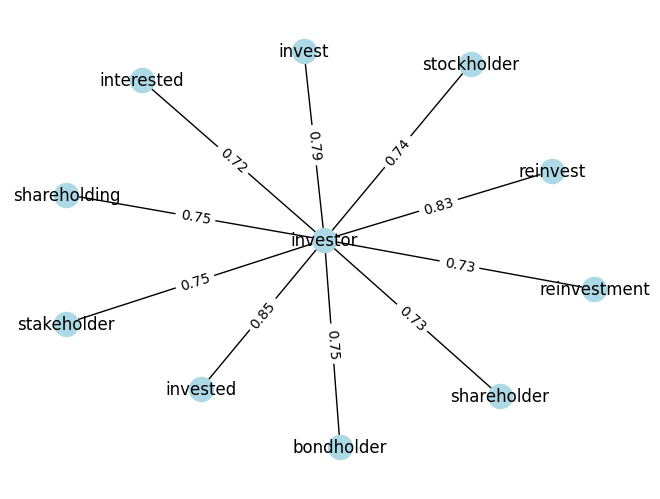

In [43]:
graph = nx.Graph()
graph.add_nodes_from(similar_to_investor_fasttext_words)
for i in range(len(similar_to_investor_fasttext)):
  graph.add_edge("investor", similar_to_investor_fasttext[i][1], weight=similar_to_investor_fasttext[i][0])
pos = nx.spring_layout(graph)
nx.draw(graph, pos, with_labels=True, node_color='lightblue')
edge_labels = {(u, v): f"{d['weight']:.2f}" for u, v, d in graph.edges(data=True)}
nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels)
plt.show()